###  <center> ULTRASOUND NERVE SEGMENTATION

<h5>- Venkatesh

<p style='text-align: justify;'> In Medical Field there are enormous facilities that has been never thought
before, they done more improvements in the field of surgery, x-rays, medicine and
lot more but still people are facing difficulties or pain in facing the treatment of
ultrasound images. These ultrasound scans are very important to detect any kind of
injury of disease in human body because it used to scan the internal tissues of the
body</p>

<p style='text-align: justify;'> Now, in this Case Study am going identify the nerve structures in ultrasound
images of various patients which is useful to decrease the pain of the patient after
surgery and speedy recover.</p>

### Data

<p style='text-align: justify;'>This Data contains the images of Ultrasound nerves of neck of patients
which are manually by the experts identified the Brachial plexus where
the patient finds pain.</p>

- The Data can be downloaded from here https://www.kaggle.com/c/ultrasound-nerve-segmentation/data
- <b> Files:</b>
    - Train :1.08GB
    - Contains 5635 images of 47 patients with their corresponding masks images.
    - Test :1.05GB
    - Contains 5508 images which are to be segmented.
    - Train masks :2.14MB
    - Sample submission :48KB

### Problem Statement

- To Detect the presence of Brachial plexus (BP) nerve where the patient is finding the pain with best possible score.

### Type

- Binary Image Classification Problem 

### Objectives and Constraints

- No Low Latency Constraints.
- Predictions have to be very accurate

### Performance Metrics

- <b> AUC </b>

- <b>Dice Coefficient</b>
 
<p style='text-align: justify;'> As it is mentioned in the Kaggle Competetion, but in production we can use <b>Recall Score</b> because the prediction should be accurate otherwise it will effect the patient. 

### Importing Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import seaborn as sb

from glob import glob 
import os
import shutil

from tqdm import tqdm_notebook as tqdm

import warnings
warnings.filterwarnings("ignore")
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score


import time
import datetime

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Flatten, MaxPooling2D, Dense, GlobalMaxPooling2D, GlobalAveragePooling2D, concatenate, Dropout,Conv2D,UpSampling2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
from tensorflow.keras import backend as K
AT = tf.data.experimental.AUTOTUNE

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [36]:
import os, sys
from PIL import Image
for infile in tqdm(x['Img_Path']):
    if infile[-3:] == "tif" or infile[-3:] == "bmp" :
        outfile = infile[:-3] + "jpeg"
        im = Image.open(infile)
        out = im.convert("RGB")
        out.save(outfile, "JPEG", quality=100)

In [37]:
import os, sys
from PIL import Image
for infile in tqdm(x['Mask_Path']):
    if infile[-3:] == "tif" or infile[-3:] == "bmp" :
        outfile = infile[:-3] + "jpeg"
        im = Image.open(infile)
        out = im.convert("RGB")
        out.save(outfile, "JPEG", quality=100)

### Reading the Data

- Final_data is the Data is obtained after classification

In [220]:
final_data=pd.read_csv("final_train_data.csv")
final_data.head()

,index,Img_Path,Mask_Path
0,0,train\10_1.jpeg,train\10_1_mask.jpeg
1,1,train\10_10.jpeg,train\10_10_mask.jpeg
2,2,train\10_100.jpeg,train\10_100_mask.jpeg
3,3,train\10_101.jpeg,train\10_101_mask.jpeg
4,6,train\10_104.jpeg,train\10_104_mask.jpeg


In [52]:
train_rles = []

for i in tqdm(list(final_data["index"])):
    if i in list(Data["Unnamed: 0"]):
        for j in range(0,Data.shape[0]):
            if Data["Unnamed: 0"][j] == i:
                train_rles.append(Data["pixels"][j])

In [54]:
final_data["RLEs"]=train_rles

In [100]:
final_data.reset_index(inplace=True)

In [101]:
for i in tqdm(range(0, final_data.shape[0])):
    if str(final_data["RLEs"][i]) == "nan":
        final_data = final_data[final_data["level_0"]!=i]

In [104]:
final_data.drop(["Unnamed: 0","level_0"],axis=1,inplace=True)

In [122]:
for i in range(0, final_data.shape[0]):
    x = final_data["RLEs"][i]

#### Function For Generating Mask Images From RLE's

In [116]:
import numpy as np 

def rleToMask(rleString,height,width):
    rows,cols = height,width
    rleNumbers = [int(numstring) for numstring in rleString.split()]
    rlePairs = np.array(rleNumbers).reshape(-1,2)
    img = np.zeros(rows*cols,dtype=np.uint8)
    for index,length in rlePairs:
        index -= 1
        img[index:index+length] = 255
    img = img.reshape(cols,rows)
    img = img.T
    return img

In [216]:
final_data.head(2)

,level_0,index,Img_Path,Mask_Path,RLEs,RLE_Mask_Path
0,0,0,train\10_1.jpeg,train\10_1_mask.jpeg,168153 9 168570 15 168984 22 169401 26 169818 ...,train\10_1_rle.jpeg
1,1,1,train\10_10.jpeg,train\10_10_mask.jpeg,96346 7 96762 16 97179 27 97595 35 98012 40 98...,train\10_10_rle.jpeg


In [218]:
Data=pd.read_csv("Final_UNS_Data.csv")
Data.shape

(5635, 5)

In [219]:
Data.head()

,Unnamed: 0,img,pixels,Train_Path,Mask_Path
0,0,1,168153 9 168570 15 168984 22 169401 26 169818 ...,C:/Users/venka/ultrasound-nerve-segmentation/t...,C:/Users/venka/ultrasound-nerve-segmentation/t...
1,1,2,96346 7 96762 16 97179 27 97595 35 98012 40 98...,C:/Users/venka/ultrasound-nerve-segmentation/t...,C:/Users/venka/ultrasound-nerve-segmentation/t...
2,2,3,121957 2 122365 26 122784 28 123202 31 123618 ...,C:/Users/venka/ultrasound-nerve-segmentation/t...,C:/Users/venka/ultrasound-nerve-segmentation/t...
3,3,4,110980 9 111393 21 111810 33 112228 43 112647 ...,C:/Users/venka/ultrasound-nerve-segmentation/t...,C:/Users/venka/ultrasound-nerve-segmentation/t...
4,4,5,NaN,C:/Users/venka/ultrasound-nerve-segmentation/t...,C:/Users/venka/ultrasound-nerve-segmentation/t...


In [224]:
rle_path = []
rles_path = []
for i in tqdm(range(0,Data.shape[0])):
    if str(Data["pixels"][i])!="nan":
        x =rleToMask(Data["pixels"][i],420,580)
        cv2.imwrite(Data["Train_Path"][i].replace(".jpeg","_rle.jpeg"),x)
        rle_path.append(Data["Train_Path"][i].replace(".jpeg","_rle.jpeg"))
        rles_path.append(Data["Train_Path"][i].replace(".jpeg","_rle.jpeg"))
    else:
        x=np.zeros((420,580,3))
        cv2.imwrite(Data["Train_Path"][i].replace(".jpeg","_rle.jpeg"),x)
        rles_path.append(Data["Train_Path"][i].replace(".jpeg","_rle.jpeg"))

In [225]:
Data["RLEs_Mask_Path"] = rles_path

In [226]:
Data.to_csv("Final_UNS_Data.csv")

In [172]:
final_data["RLE_Mask_Path"] = rle_path
final_data.to_csv("Segmentation_Data_Train.csv")

In [173]:
Img_Height=96
Img_Width=96
Batch_Size = 128

## Segmentation

###  Making Model For Segmentation

### Splitting of Train Data

In [187]:
from sklearn.model_selection import train_test_split
xx=final_data['Img_Path'].tolist()
yy=final_data['RLE_Mask_Path'].tolist()
x_train_final,x_cv_final,y_train_final,y_cv_final=train_test_split(xx,yy,test_size=.10,random_state=42)

In [204]:
def _parse_fn(ImgFile, Label):
    Img_Path = tf.io.read_file(ImgFile)
    Img_Dec = tf.image.decode_jpeg(Img_Path)
    Img_Dec = tf.image.rgb_to_grayscale(Img_Dec)
    Img_Nor = (tf.cast(Img_Dec, tf.float32)/255)
    Final_Img = tf.image.resize(Img_Nor, (Img_Height, Img_Width))
    
    Mask_Path = tf.io.read_file(Label)
    Mask_Dec = tf.image.decode_jpeg(Mask_Path)
    Mask_Dec = tf.broadcast_to(Mask_Dec, (420,580,3))
    Mask_Dec = tf.image.rgb_to_grayscale(Mask_Dec)
    Mask_Nor = (tf.cast(Mask_Dec, tf.float32)/255)
    Final_Mask = tf.image.resize(Mask_Nor, (Img_Height, Img_Width))
    
    return Final_Img, Final_Mask


In [205]:
# Creating Dataset from slices of Image Path's and Labels Using tf.Data
T_Data = tf.data.Dataset.from_tensor_slices((tf.constant(x_train_final), tf.constant(y_train_final)))
V_Data=tf.data.Dataset.from_tensor_slices((tf.constant(x_cv_final), tf.constant(y_cv_final)))

# Parsing The Images to Pixel Values
T_Data=T_Data.map(_parse_fn,num_parallel_calls=AT)
V_Data=V_Data.map(_parse_fn,num_parallel_calls=AT)

# Batch the Images
T_Data=T_Data.batch(Batch_Size)
V_Data =V_Data.batch(Batch_Size)

# Prefetching Batch
T_Data=T_Data.prefetch(buffer_size=AT)
V_Data=V_Data.prefetch(buffer_size=AT)

### Metric

In [206]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

#### Gradient Tape

#### Referred :
 - https://www.tensorflow.org/api_docs/python/tf/GradientTape
 - https://en.wikipedia.org/wiki/Automatic_differentiation
 - https://www.pyimagesearch.com/2020/03/23/using-tensorflow-and-gradienttape-to-train-a-keras-model/ 

In [207]:
K.clear_session()
Init_LR=0.0001
loss = tf.keras.losses.BinaryCrossentropy()

optimizer = Adam(lr=Init_LR)
Opt_Adam =Adam(lr=Init_LR)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.BinaryAccuracy(name='val_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

### Model Architecture

####  U-Net

<b>Referred : </b>
- https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/
- https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py

In [208]:
def get_unet():
    inputs = Input((Img_Height, Img_Width, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    #model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [209]:
#https://www.tensorflow.org/tutorials/distribute/save_and_load
def SEGModelGT(Epochs,checkpoint,manager,File_Name,modelc):
    
    start_time=time.clock()
    
    print("\nInitializing Parameters . . .")


    train_loss_results = []
    train_accuracy_results = []

    val_loss_results = []
    val_accuracy_results = []
    
    train_dice_coef=[]
    val_dice_coef=[]
    
    iepoch=0
    T_step=0
    V_step=0
    
    # Defining GradientTape
    
    @tf.function
    def GT(modelc,X_batch,Y_batch):    
        with tf.GradientTape() as tape:
            Y_Pred=modelc(X_batch, training=True)
            
            loss_values=loss(Y_batch, Y_Pred)
            gradients=tape.gradient(loss_values, modelc.trainable_weights)
            Opt_Adam.apply_gradients(zip(gradients, modelc.trainable_weights))
        
            return loss_values,Y_Pred
        
    
    
    # Initializing the Identifiers
    
    
    train_summary_writer = tf.summary.create_file_writer(logdir="logs/SEG_UNET/train")
   
    val_summary_writer = tf.summary.create_file_writer(logdir="logs/SEG_UNET/val")
    save_path='ModelsGT/UNS_UNET/SEG'
    
    # Training the Model
    
    print("\nTraining the Model . . .")
    print("\nChecking for the Checkpoint Files . . .")
    
    # Checking for the Checkpoints
    checkpoint.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("\nFound . .  !\nRestoring . . ")
        print("\nRestored from {}".format(manager.latest_checkpoint))
        ind=manager.latest_checkpoint.find("ckpt")
        iepoch=int(manager.latest_checkpoint[(ind+5):])
        print("\nTraining from Epoch {}".format(int(iepoch)+1))
        T_step=iepoch*(len(x_train)//Batch_Size)
        V_step=iepoch*(len(x_test)//Batch_Size)
    else:
        print("\nNot Found . . !")
        print("\nTraining the Model From Scratch . . .")
    
    Epochs=Epochs+int(iepoch)
    for epoch in range(int(iepoch),Epochs):

        print("\nEpoch {}/{}".format(epoch+1, Epochs))
        print("[", end ="")
        c=0
        # for loop iterate over batches
        for (X_batch, y_batch) in (T_Data):
        
            
               
        
            # GradientTape
            loss_values,y_pred=GT(modelc,X_batch,y_batch)

            train_loss(loss_values)
            train_accuracy(y_batch, y_pred)
            train_DICE_COEF=dice_coef(y_batch,y_pred)
            

            train_loss_results.append(loss_values)
            train_accuracy_results.append(train_accuracy.result())
            train_dice_coef.append(train_DICE_COEF)
            
            c+=1
            T_step+=1
            #train_accuracy.reset_states
            #with train_summary_writer.as_default():
                #tf.summary.scalar(f'Step Loss/Train', loss_values, step=T_step)
                #tf.summary.scalar(f'Step Accuracy/Train', train_accuracy.result(), step=T_step)
                #tf.summary.scalar(f'Step AUC/Train', train_AUC, step=T_step)
        # Tensorboard Summary Writer    
        #with train_summary_writer.as_default():
            #tf.summary.scalar(f'Epoch Loss/Train', loss_values, step=epoch)
            #tf.summary.scalar(f'Epoch Accuracy/Train', train_accuracy.result(), step=epoch+1)
            #tf.summary.scalar(f'Epoch AUC/Train', train_AUC, step=epoch+1)
        
        
        # For Loop Iterating ove Validation Data Batches
        for (X_batch, y_batch) in (V_Data):

            # GradientTape
            val_loss_values,y_pred=GT(modelc,X_batch,y_batch)

            val_loss(val_loss_values)
            val_accuracy(y_batch, y_pred)
            val_DICE_COEF=dice_coef(y_batch,y_pred)


            val_loss_results.append(val_loss_values)
            val_accuracy_results.append(val_accuracy.result())
            val_dice_coef.append(val_DICE_COEF)
            
            c+=1
            V_step+=1
            #val_accuracy.reset_states
            
            #with val_summary_writer.as_default():
                #tf.summary.scalar(f'Step Loss/Validation', val_loss_values, step=V_step)
                #tf.summary.scalar(f'Step Accuracy/Validation', val_accuracy.result(), step=V_step)
                #tf.summary.scalar(f'Step AUC/Validation', val_AUC, step=V_step)
        
        # Tensorboard Summary Writer
        with tf.name_scope("per_epoch_params"):
            with train_summary_writer.as_default():
                tf.summary.scalar('Epoch Loss', loss_values, step=epoch)
                tf.summary.scalar('Epoch Accuracy', train_accuracy.result(), step=epoch)
                tf.summary.scalar('Epoch Dice coef', train_DICE_COEF, step=epoch)
                train_summary_writer.flush()
            
            with val_summary_writer.as_default():
                tf.summary.scalar('Epoch Loss', val_loss_values, step=epoch)
                tf.summary.scalar('Epoch Accuracy', val_accuracy.result(), step=epoch)
                tf.summary.scalar('Epoch Dice coef', val_DICE_COEF, step=epoch)
                val_summary_writer.flush()

        # Creating Checkpoint using tf.train.Checkpoint
        checkpoint = tf.train.Checkpoint(optimizer=Opt_Adam, model=modelc)
        print("]")
        Epoch_Stats = 'Training loss: {:.4f}, Training accuracy: {:.4f}, Train Dice coef: {:.4f} Validation loss: {:.4f}, Validation accuracy: {:.4f}, Validation Dice coef: {:.4f}'
        print(Epoch_Stats.format(loss_values,train_accuracy.result() * 100,train_DICE_COEF,val_loss_values,val_accuracy.result()*100,val_DICE_COEF))
    
        Checkpoint_save_path = manager.save()
        print("Saved Checkpoint for Epoch {}: {}".format(epoch+1, Checkpoint_save_path))
    #checkpoint.save(checkpoint_path+'/')
    z=modelc.predict(V_Data)
    # Saving the Model using tf.saved_model
    tf.saved_model.save(modelc,save_path+'/')
    
    # Displaying Information related to this run
    print("\n\nCorresponding Files to this Run : ")
    print("\nTensorBoard Log Files : logs/GT/SEG_UNET".format(File_Name))
    print("\nCheckpoint Files : CheckponitsGT/{}".format(File_Name))
    print("\nModel Files : {}".format(save_path))
        
    print("\n\nTime Taken For This Process : "+ str((time.clock()-start_time)) + " Sec")

In [210]:
def SEG_UNET(Img_Height,Img_Width,Epochs,File_Name):
    
    # Initializing Optimizer
    
    print("\nInitializing Optimizer . . .")
    Opt_Adam =Adam(lr=Init_LR)
    
    # Building Model
    print("\nBuilding Model . . .")
    modelx = get_unet()
    #modelx.build(input_shape=(None, Img_Height,Img_Width,3))
    
    # Creating Checkpoint Objects
    checkpoint = tf.train.Checkpoint(optimizer=Opt_Adam,model=modelx)
    manager = tf.train.CheckpointManager(checkpoint, 'CheckponitsGT/SEG_UNET_' + File_Name, max_to_keep=None)
    
    # Calling the Training Module
    K.clear_session()
    SEGModelGT(Epochs=Epochs,checkpoint=checkpoint,manager=manager,File_Name=File_Name,modelc=modelx)

In [211]:
K.clear_session()
Model_Name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
SEG_UNET(Img_Height=96,Img_Width=96,Epochs=20,File_Name=Model_Name)


Initializing Optimizer . . .

Building Model . . .

Initializing Parameters . . .

Training the Model . . .

Checking for the Checkpoint Files . . .

Not Found . . !

Training the Model From Scratch . . .

Epoch 1/20
[]
Training loss: 0.6155, Training accuracy: 94.0115, Train Dice coef: 0.0530 Validation loss: 0.5920, Validation accuracy: 96.7928, Validation Dice coef: 0.0516
Saved Checkpoint for Epoch 1: CheckponitsGT/SEG_UNET_20200907-134501\ckpt-1

Epoch 2/20
[]
Training loss: 0.2157, Training accuracy: 95.3853, Train Dice coef: 0.0172 Validation loss: 0.2233, Validation accuracy: 96.7928, Validation Dice coef: 0.0218
Saved Checkpoint for Epoch 2: CheckponitsGT/SEG_UNET_20200907-134501\ckpt-2

Epoch 3/20
[]
Training loss: 0.1773, Training accuracy: 95.8432, Train Dice coef: 0.0163 Validation loss: 0.1714, Validation accuracy: 96.7928, Validation Dice coef: 0.0168
Saved Checkpoint for Epoch 3: CheckponitsGT/SEG_UNET_20200907-134501\ckpt-3

Epoch 4/20
[]
Training loss: 0.1138, Traini

In [292]:
# Parse Function

def _parse_fn_test(ImgFile):
    Img_Path = tf.io.read_file(ImgFile)
    Img_Dec = tf.image.decode_jpeg(Img_Path)
    Img_Dec = tf.image.rgb_to_grayscale(Img_Dec)
    Img_Nor = (tf.cast(Img_Dec, tf.float32)/255)
    Final_Img = tf.image.resize(Img_Nor, (Img_Height, Img_Width))
    return Final_Img

In [293]:
# Creating Dataset from slices of Image Path's and Labels Using tf.Data
Train_Data_final = tf.data.Dataset.from_tensor_slices(tf.constant(x_train_final))
                                            
# Parsing The Images to Pixel Values
Train_Data_final=Train_Data_final.map(_parse_fn_test,num_parallel_calls=AT)

# Batch the Images
Train_Data_final=Train_Data_final.batch(Batch_Size)

# Prefetching Batch
Train_Data_final=Train_Data_final.prefetch(buffer_size=AT)

In [294]:
# Creating Dataset from slices of Image Path's and Labels Using tf.Data
CV_Data_final = tf.data.Dataset.from_tensor_slices(tf.constant(x_cv_final))
                                            
# Parsing The Images to Pixel Values
CV_Data_final=CV_Data_final.map(_parse_fn_test,num_parallel_calls=AT)

# Batch the Images
CV_Data_final=CV_Data_final.batch(Batch_Size)

# Prefetching Batch
CV_Data_final=CV_Data_final.prefetch(buffer_size=AT)

### Loading the best model

In [212]:
K.clear_session()
model_final=tf.keras.models.load_model('ModelsGT/UNS_UNET/SEG')

In [295]:
MASK_CV_data = model_final.predict(CV_Data_final, verbose=1)
np.save('imgs_mask_cv.npy', MASK_CV_data)

2/2 [==============================] - 0s 241ms/step


In [213]:
def RLE(label):
    from itertools import chain
    x = label.transpose().flatten()
    y = np.where(x > 0.05)[0]
   
    if len(y) < 10:  # consider as empty
        return ''
    z = np.where(np.diff(y) > 1)[0]
   
    start = np.insert(y[z+1], 0, y[0])
    end = np.append(y[z], y[-1])
    length = end - start
    res = [[s+1, l+1] for s, l in zip(list(start), list(length))]
    res = list(chain.from_iterable(res))
    return ' '.join([str(r) for r in res])

In [17]:
mask_cv=np.load('imgs_mask_cv.npy')
rles_cv = []
for i in tqdm(range(mask_cv.shape[0])):
    img_mask = mask_cv[i]
    rle_cv = RLE(img_mask)
    rles_cv.append(rle_cv)

### Reading The Test Data

In [55]:
import os, sys
from PIL import Image
for infile in tqdm(test):
    if infile[-3:] == "tif" or infile[-3:] == "bmp" :
        outfile = infile[:-3] + "jpeg"
        im = Image.open(infile)
        out = im.convert("RGB")
        out.save(outfile, "JPEG", quality=100)

In [18]:
test = [img for img in glob("test/*.jpeg") if 'mask' not in img]
len(test)

5508

In [19]:
img = cv2.imread(test[0])
height, width, channels = img.shape
print('Image dimensions: ' + str(height) + 'h x ' + str(width) + 'w - ' + str(channels) + ' channels')

Image dimensions: 420h x 580w - 3 channels


### prediction of test data with Classification model

In [20]:
Test_Images = []
Path = "C:/Users/venka/ultrasound-nerve-segmentation/test"
for i in os.listdir(Path):
    if i.split(".")[1] == 'jpeg':
        Test_Images.append(i.split(".")[0])

In [21]:
def _parse_fn_TEST(ImgFile):
    Img_Path = tf.io.read_file(ImgFile)
    Img_Dec = tf.image.decode_jpeg(Img_Path)
    #Img_Dec = tf.image.rgb_to_grayscale(Img_Dec)
    Img_Nor = (tf.cast(Img_Dec, tf.float32)/255)
    Final_Img = tf.image.resize(Img_Nor, (Img_Height, Img_Width))
    return Final_Img

In [22]:
# Creating Dataset from slices of Image Path's and Labels Using tf.Data
Test_Data = tf.data.Dataset.from_tensor_slices(tf.constant(test))
                                            
# Parsing The Images to Pixel Values
Test_Data=Test_Data.map(_parse_fn_TEST,num_parallel_calls=AT)

# Batch the Images
Test_Data=Test_Data.batch(Batch_Size)

# Prefetching Batch
Test_Data=Test_Data.prefetch(buffer_size=AT)

In [23]:
K.clear_session()
modelx=tf.keras.models.load_model('ModelsGT/UNS_D169/1e-4')

In [24]:
Test_Results=modelx.predict(Test_Data)
Test_Results=Test_Results.ravel().tolist()

In [25]:
k=0
Seg_Test_Ind=[]
Mask_Index = []
for j in Test_Results:
    if j>0.6:
        Seg_Test_Ind.append(test[k])
        Mask_Index.append(Test_Images[k])
    k+=1   

### Segmentation on Test Data

In [26]:
TEST = np.zeros(((pd.Series(Seg_Test_Ind).shape[0]), 96, 96, 1), dtype=np.float32)
for id_,path in tqdm(enumerate(list(Seg_Test_Ind))):
    
    Img_Path = tf.io.read_file(path)
    Img_Dec = tf.image.decode_jpeg(Img_Path)
    Img_Dec = tf.image.rgb_to_grayscale(Img_Dec)
    Img_Nor = (tf.cast(Img_Dec, tf.float32)/255)
    Final_Img = tf.image.resize(Img_Nor, (Img_Height, Img_Width))
    
    TEST[id_]=Final_Img

In [27]:
TEST.shape

(1314, 96, 96, 1)

In [28]:
np.save("final_test_imgs.npy",TEST)

In [29]:
Test_final=np.load("final_test_imgs.npy")

In [30]:
MASK_TEST = model_final.predict(TEST)
np.save('imgs_mask_test.npy', MASK_TEST)

### Run Length Encoding (RLE)

In [31]:
def run_length_enc(label):
    label = label.numpy()
    from itertools import chain
    x = label.transpose().flatten()
    y = np.where(x > 0.05)[0]
    if len(y) < 10:  # consider as empty
        return ''
    z = np.where(np.diff(y) > 1)[0]
    start = np.insert(y[z+1], 0, y[0])
    end = np.append(y[z], y[-1])
    length = end - start
    res = [[s+1, l+1] for s, l in zip(list(start), list(length))]
    res = list(chain.from_iterable(res))
    return ' '.join([str(r) for r in res])

In [32]:
# Creating Dataset from slices of Image Path's and Labels Using tf.Data
Test_Data_RLE = tf.data.Dataset.from_tensor_slices(tf.constant(MASK_TEST))
                                            
# Parsing The Images to Pixel Values
Test_Data_RLE=Test_Data_RLE.map(lambda val : tf.py_function(run_length_enc,[val],tf.string))

In [33]:
rles_test = list(Test_Data_RLE.as_numpy_iterator())

In [34]:
results = []
imgs = []

for i in Test_Images:
    
    if i in Mask_Index:
        
        for j in range(0,len(Mask_Index)):
            
            if i==Mask_Index[j]:
                results.append(rles_test[j])
                imgs.append(Mask_Index[j])
    else:
        results.append(" ")

In [35]:
sub = pd.DataFrame({"img":Test_Images,"pixels":results})

In [36]:
sub.to_csv("Submission_Latest.csv",header=True,index=False)

In [37]:
x = pd.read_csv("Submission_Latest.csv")
x.head()

,img,pixels
0,1,
1,10,b'4158 3 4250 11 4344 14 4438 17 4533 19 4627 ...
2,100,
3,1000,
4,1001,


### Predicting on Some Labelled Dataset

In [229]:
Data = pd.read_csv("Final_UNS_Data.csv")
Data.head(2)

,Unnamed: 0,Unnamed: 0.1,img,pixels,Train_Path,Mask_Path,RLEs_Mask_Path
0,0,0,1,168153 9 168570 15 168984 22 169401 26 169818 ...,C:/Users/venka/ultrasound-nerve-segmentation/t...,C:/Users/venka/ultrasound-nerve-segmentation/t...,C:/Users/venka/ultrasound-nerve-segmentation/t...
1,1,1,2,96346 7 96762 16 97179 27 97595 35 98012 40 98...,C:/Users/venka/ultrasound-nerve-segmentation/t...,C:/Users/venka/ultrasound-nerve-segmentation/t...,C:/Users/venka/ultrasound-nerve-segmentation/t...


In [273]:
# Sampling Some Data For Prediction

Data_P = Data[49:65]
Data_P.reset_index(inplace=True)

In [274]:
def _parse_fn_(ImgFile):
    Img_Path = tf.io.read_file(ImgFile)
    Img_Dec = tf.image.decode_jpeg(Img_Path)
    Img_Nor = (tf.cast(Img_Dec, tf.float32)/255)
    Final_Img = tf.image.resize(Img_Nor, (Img_Height, Img_Width))
    return Final_Img

In [275]:
# Creating Dataset from slices of Image Path's and Labels Using tf.Data
Data_Pred = tf.data.Dataset.from_tensor_slices(tf.constant(list(Data_P["Train_Path"])))
                                            
# Parsing The Images to Pixel Values
Data_Pred = Data_Pred.map(_parse_fn_,num_parallel_calls=AT)

# Batch the Images
Data_Pred = Data_Pred.batch(Batch_Size)

# Prefetching Batch
Data_Pred = Data_Pred.prefetch(buffer_size=AT)

In [276]:
K.clear_session()
modelx=tf.keras.models.load_model('ModelsGT/UNS_D169/1e-4')

In [277]:
Classification_Results = modelx.predict(Data_Pred)
Classification_Results = Classification_Results.ravel().tolist()
Clf_Res = []
Data_Index = []
k=0
for j in Classification_Results:
    if j>0.6:   
        Data_Index.append(Data_P["Train_Path"][k])
        Clf_Res.append(1)
    else:
        Clf_Res.append(0)
    k+=1   

In [278]:
# Parse Function

def _parse_fn_Seg(ImgFile):
    Img_Path = tf.io.read_file(ImgFile)
    Img_Dec = tf.image.decode_jpeg(Img_Path)
    Img_Dec = tf.image.rgb_to_grayscale(Img_Dec)
    Img_Nor = (tf.cast(Img_Dec, tf.float32)/255)
    Final_Img = tf.image.resize(Img_Nor, (Img_Height, Img_Width))
    return Final_Img

In [279]:
# Creating Dataset from slices of Image Path's and Labels Using tf.Data
Seg_Data = tf.data.Dataset.from_tensor_slices(tf.constant(Data_Index))
                                            
# Parsing The Images to Pixel Values
Seg_Data = Seg_Data.map(_parse_fn_Seg,num_parallel_calls=AT)

# Batch the Images
Seg_Data = Seg_Data.batch(Batch_Size)

# Prefetching Batch
Seg_Data = Seg_Data.prefetch(buffer_size=AT)

In [280]:
K.clear_session()
model_final=tf.keras.models.load_model('ModelsGT/UNS_UNET/SEG')

In [281]:
Pred_Mask = model_final.predict(Seg_Data)

In [282]:
def run_length_enc(label):
    label = label.numpy()
    from itertools import chain
    x = label.transpose().flatten()
    y = np.where(x > 0.05)[0]
    if len(y) < 10:  
        return ''
    z = np.where(np.diff(y) > 1)[0]
    start = np.insert(y[z+1], 0, y[0])
    end = np.append(y[z], y[-1])
    length = end - start
    res = [[s+1, l+1] for s, l in zip(list(start), list(length))]
    res = list(chain.from_iterable(res))
    return ' '.join([str(r) for r in res])

In [283]:
# Creating Dataset from slices of Image Path's and Labels Using tf.Data
Pred_Data_RLE = tf.data.Dataset.from_tensor_slices(tf.constant(Pred_Mask))
                                            

Pred_Data_RLE = Pred_Data_RLE.map(lambda val : tf.py_function(run_length_enc,[val],tf.string))


In [284]:
RLES_Pred = list(Pred_Data_RLE.as_numpy_iterator())

In [285]:
Pred_RLE = []
indexs = []
k=0
for i in range(0,len(Clf_Res)):
    if Clf_Res[i] == 0:
        Pred_RLE.append("")
    else:
        Pred_RLE.append(RLES_Pred[k])
        indexs.append(i)
        k+=1

In [286]:
Results = pd.DataFrame({"Img_Num":list(Data_P["img"]),"Train_RLE":list(Data_P["pixels"]),"Predicted_Results":Clf_Res,"Predicted_RLE":Pred_RLE})
Results

,Img_Num,Train_RLE,Predicted_Results,Predicted_RLE
0,50,145025 32 145443 36 145861 39 146275 49 146691...,1,b'3582 6 3675 12 3770 16 3865 20 3959 26 4054 ...
1,51,126576 7 126987 20 127403 26 127819 32 128238 ...,1,b'3678 11 3773 15 3865 22 3960 25 4053 29 4147...
2,52,121963 10 122375 22 122794 24 123213 25 123626...,1,b'3582 3 3586 1 3675 10 3770 14 3865 20 3959 2...
3,53,74547 8 74961 18 75379 23 75798 26 76214 31 76...,1,b'3586 1 3678 11 3773 13 3787 1 3867 18 3886 1...
4,54,127405 12 127819 23 128237 26 128655 29 129070...,1,b'1 1 3393 3 3484 13 3579 17 3675 19 3769 23 3...
5,55,NaN,0,
6,56,156344 19 156758 28 157176 33 157593 38 158010...,1,b'3492 1 3583 14 3677 19 3772 20 3865 24 3961 ...
7,57,115194 12 115610 18 116025 30 116439 46 116857...,1,b'1 1 3582 7 3675 14 3770 20 3865 22 3959 25 4...
8,58,NaN,0,
9,59,NaN,0,


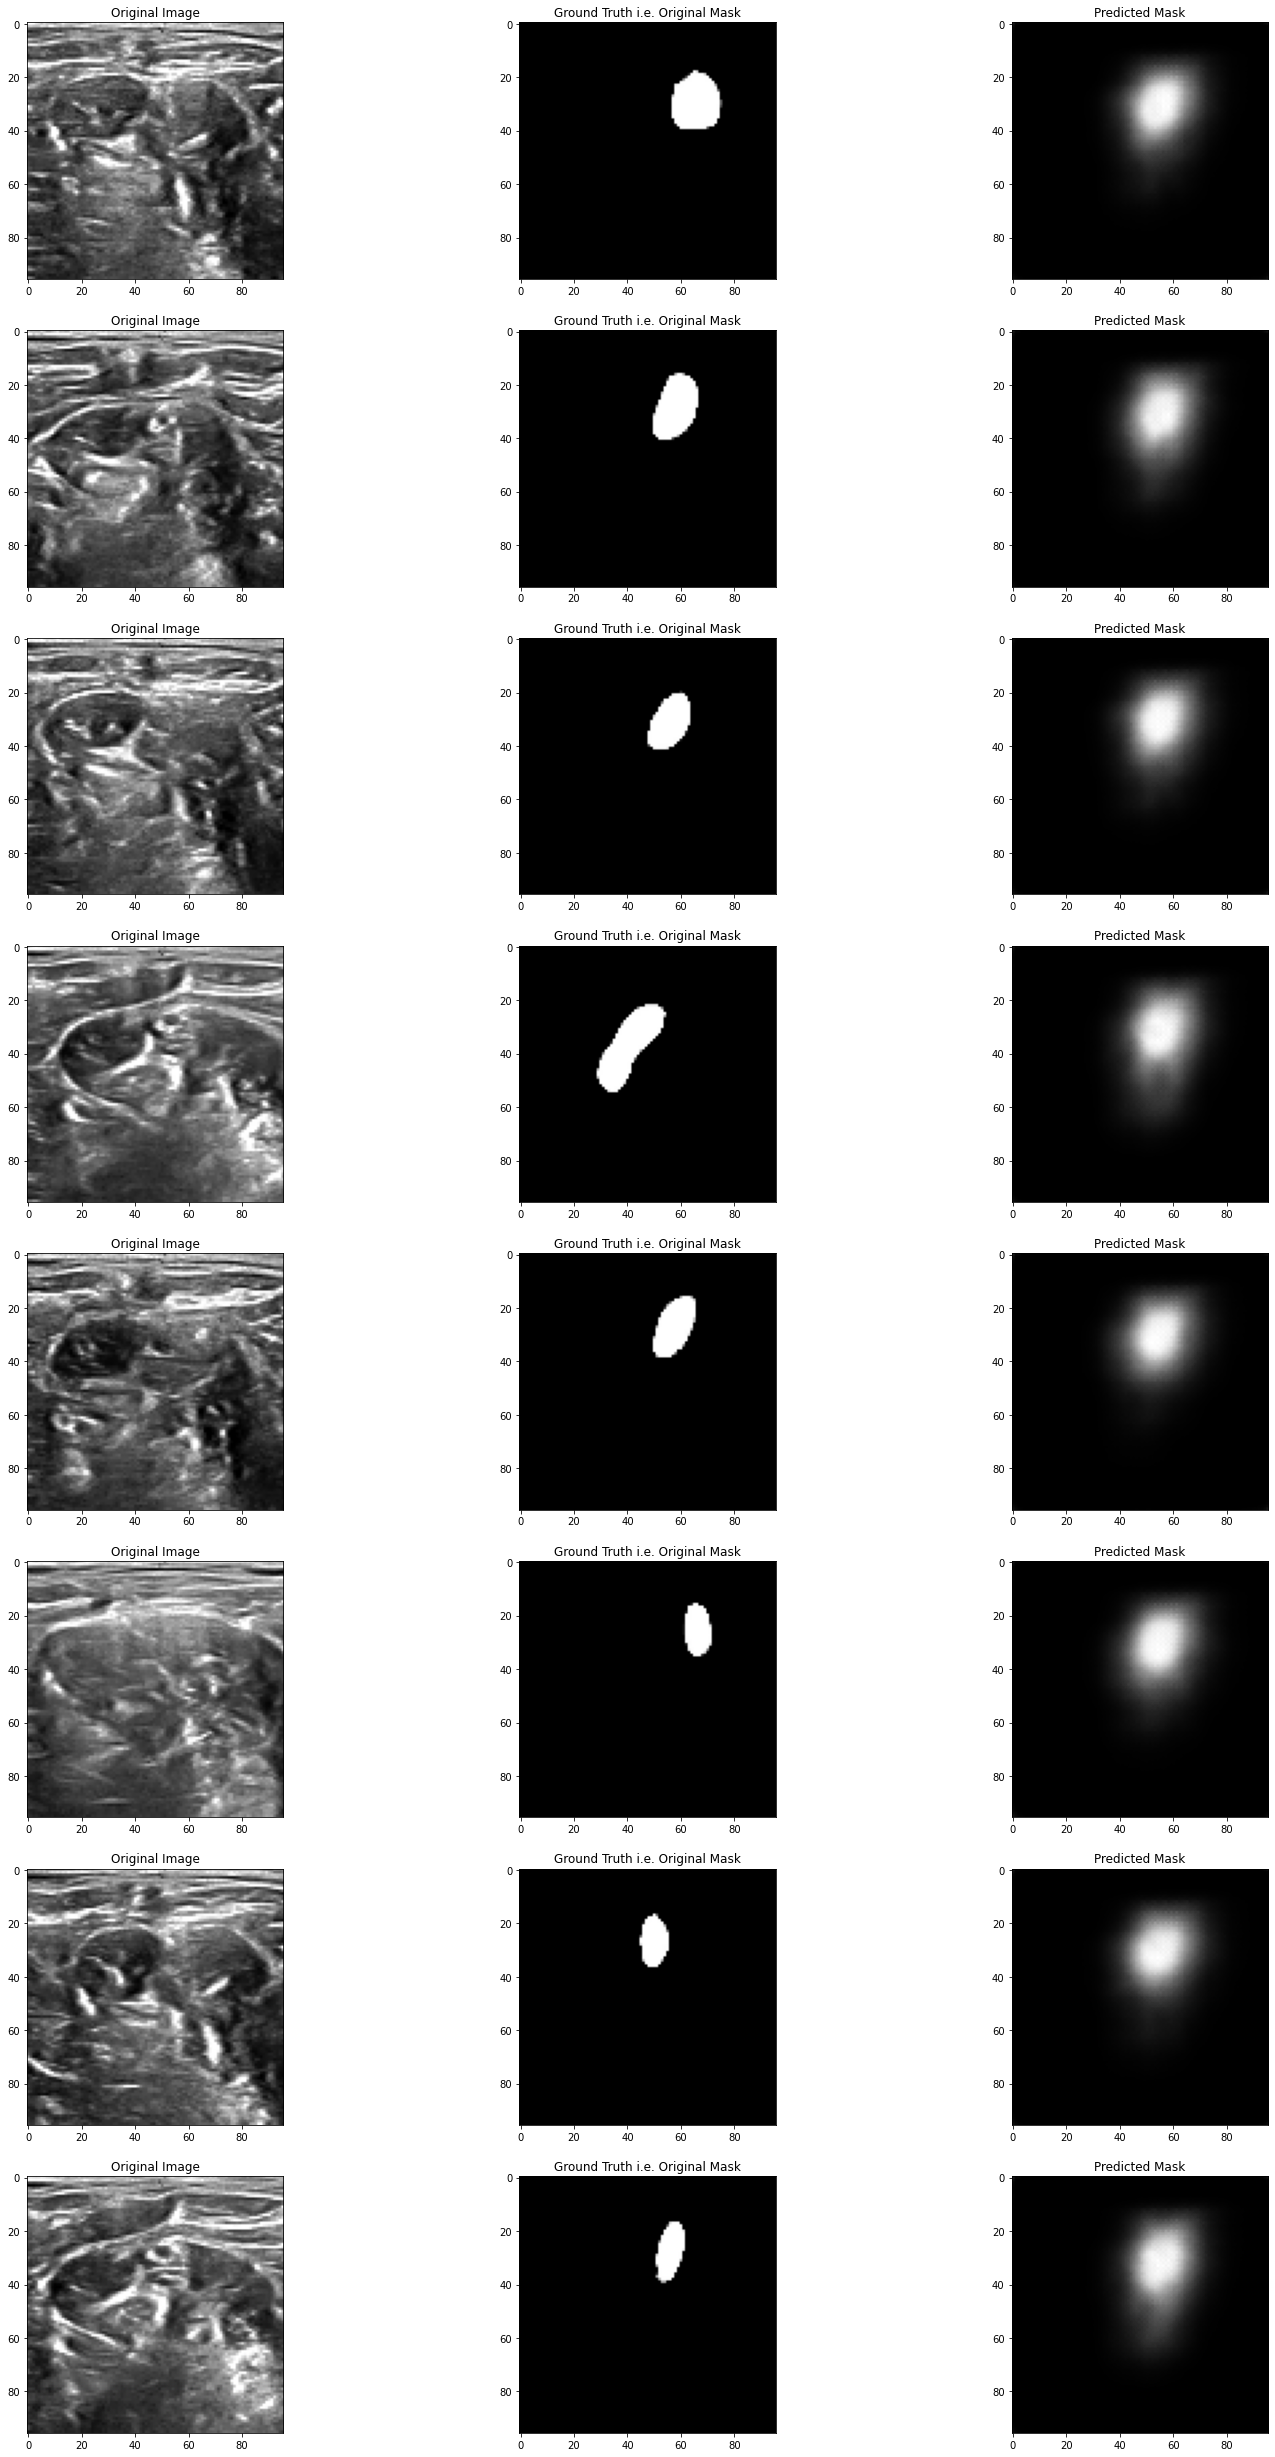

In [291]:
import cv2

plt.figure(figsize=(25,50))
k=0
j=0
for i in indexs:
    Original_Img = cv2.resize(cv2.imread(Data_P["Train_Path"][i]),(96,96))
    Original_Mask_Img = cv2.resize(cv2.imread(Data_P["RLEs_Mask_Path"][i]),(96,96))
    Pred_Mask_Img = Pred_Mask[j]
    N_Rows =len(Pred_Mask)+1
    j+=1
    k+=1
    plt.subplot(N_Rows,3,k)
    plt.imshow(Original_Img)
    plt.title("Original Image")
    k+=1
    plt.subplot(N_Rows,3,k)
    plt.imshow(Original_Mask_Img)
    plt.title("Ground Truth i.e. Original Mask")
    k+=1
    plt.subplot(N_Rows,3,k)
    plt.imshow(Pred_Mask_Img.squeeze(),cmap='gray')
    plt.title("Predicted Mask")

### Conclusions:

- I Understand the data and performed some analysis like EDA and got some inferences as data is Imbalanced and there are no missing values. while in cleaning the data i got a inference that there are too dark and too bright images
-  Then fed the data into Classification model.After all trials and experiments and i got best model on Pretrained Densenet169 Architetcture with dropout rate of 0.5 and learning rate of 0.0001.
- I Choose Key Perforomance Metirc as AUC. I got the best score with AUC after all experiments.
- In Classification I got the Images which are Having Mask(i.e having BP Nerve).
- I fixed the Threshold based on Confusion Matrix, AUC Score and F1 Score. With the help of threshold i get the images which have mask(BP Nerve)
- Then I fed these Images which are Classified as 1 (i.e Presence of BP Nerve) to Segmentation model.
- The Model Architecture which i used for Segmentation is Pretrained U-Net.
- For the Segmentation The Key Performace Metirc used is Dice Coefficient.
- with the Help of That U-Net model segmented the image where the nerve is present.
- On the top of those images RLE are Generated.